In [2]:
# === 1. Load Libraries ===
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from statsmodels.stats.multitest import multipletests

CLEANS MUTATION MATRIX, ONLY KEEPS SAMPLE AND GENE COLUMNS, REMOVES NA AND DUPLICCATES, ADDS NEW COLUMN "MUTATED"
rows=samples, columns=genes, values=0 or 1, removes -01 from TCGA code

In [3]:
# Load mutation data
mutation_raw = pd.read_csv("mutations", sep="\t")

# Keep only necessary columns
mutation_subset = mutation_raw[["sample", "gene"]].dropna().drop_duplicates()
mutation_subset["mutated"] = 1

# Pivot to binary matrix
mutation_matrix = mutation_subset.pivot_table(
    index="sample", columns="gene", values="mutated", fill_value=0
)
mutation_matrix.index = mutation_matrix.index.str.replace("-01", "", regex=False)


Loads and cleans phenotype dataset, removes all columns except sample and outcome, maps outcome to 0 or 1, drops nulls

In [ ]:
# Load phenotype
phenotype_df = pd.read_csv("phenotype", sep="\t")

# Extract and map labels
response_df = phenotype_df[["sampleID", "primary_therapy_outcome_success"]].copy()
response_df.columns = ["sample", "outcome"]
response_df["sample"] = response_df["sample"].str.replace("-01", "", regex=False)
response_map = {
    "Complete Remission/Response": 1,
    "Partial Remission/Response": 1,
    "Progressive Disease": 0,
    "Stable Disease": 0
}
response_df["response"] = response_df["outcome"].map(response_map)
response_df.dropna(subset=["response"], inplace=True)

Merges cleaned mutations and phenotype, runs fisher test on it and saves results to dataframe

In [5]:
# Merge and filter by labeled samples
mutation_with_response = mutation_matrix.merge(response_df[["sample", "response"]],
                                                left_index=True, right_on="sample")
response = mutation_with_response["response"]
X_mut = mutation_with_response.drop(columns=["sample", "response"])

# Fisher test
p_values = {}
for gene in X_mut.columns:
    a = ((X_mut[gene] == 1) & (response == 1)).sum()
    b = ((X_mut[gene] == 1) & (response == 0)).sum()
    c = ((X_mut[gene] == 0) & (response == 1)).sum()
    d = ((X_mut[gene] == 0) & (response == 0)).sum()
    _, p = fisher_exact([[a, b], [c, d]])
    p_values[gene] = p

fisher_results = pd.DataFrame.from_dict(p_values, orient='index', columns=["p_value"])
X_sig_mut = X_mut[fisher_results[fisher_results["p_value"] < 0.05].index]


loads and cleans expressions dataset, merges with phenotype, runs t test, saves results

In [7]:
# Load and transpose expression
expression_df = pd.read_csv("expression", sep="\t", index_col=0).transpose()
expression_df.index = expression_df.index.str.replace("-01", "", regex=False)

# Align with response
expression_with_response = expression_df.merge(response_df[["sample", "response"]],
                                               left_index=True, right_on="sample")
X_expr = expression_with_response.drop(columns=["sample", "response"])
y_expr = expression_with_response["response"]

# t-test
responder_expr = X_expr[y_expr == 1]
nonresponder_expr = X_expr[y_expr == 0]
ttest_results = {
    gene: ttest_ind(responder_expr[gene], nonresponder_expr[gene], equal_var=False)[1]
    for gene in X_expr.columns
}
ttest_df = pd.DataFrame.from_dict(ttest_results, orient="index", columns=["p_value"])
top_genes_by_p = ttest_df.sort_values("p_value").head(500).index.tolist()
X_sig_expr_topN = X_expr[top_genes_by_p]

cleans, removes 01 at the end

In [11]:
# Force index to string type first
X_sig_mut.index = X_sig_mut.index.astype(str).str.replace("-01", "", regex=False)
X_sig_expr_topN.index = X_sig_expr_topN.index.astype(str).str.replace("-01", "", regex=False)

In [13]:
# Clean y_expr index to match X matrices
y_expr.index = y_expr.index.astype(str).str.replace("-01", "", regex=False)

aligns and intersects mutations + expressions dataset, builds unified feature matrix, prepares for training

In [ ]:
# Align and combine
X_sig_mut.index = X_sig_mut.index.str.replace("-01", "", regex=False)
X_sig_expr_topN.index = X_sig_expr_topN.index.str.replace("-01", "", regex=False)

common_samples = X_sig_mut.index.intersection(X_sig_expr_topN.index) #find common samples across both mutations and expressions
#filter to common samples
X_mut_common = X_sig_mut.loc[common_samples]
X_expr_common = X_sig_expr_topN.loc[common_samples]
y_common = y_expr.loc[common_samples]

#combine features into one matrix
X_combined = pd.concat([X_mut_common, X_expr_common], axis=1)

trained model

In [19]:
X = X_combined.values
y = y_common.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_array))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(
    X_train_scaled, y_train,
    epochs=50, batch_size=16,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=1
)

y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_prob)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\n✅ Combined Model — Test AUC: {auc:.3f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)


Epoch 1/50


/opt/anaconda3/envs/ml-env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6978 - auc: 0.5049 - loss: 3.7435 - val_accuracy: 0.6522 - val_auc: 0.6653 - val_loss: 3.4788
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7138 - auc: 0.8356 - loss: 3.1872 - val_accuracy: 0.7246 - val_auc: 0.7008 - val_loss: 3.0748
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7662 - auc: 0.8432 - loss: 3.0151 - val_accuracy: 0.6957 - val_auc: 0.7068 - val_loss: 2.9485
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7891 - auc: 0.9077 - loss: 2.7869 - val_accuracy: 0.7826 - val_auc: 0.7441 - val_loss: 2.7779
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8360 - auc: 0.9292 - loss: 2.6266 - val_accuracy: 0.8116 - val_auc: 0.7788 - val_loss: 2.5980
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9018 - auc: 0.9671 - loss: 2.4019 - val_accuracy: 0.8116 - val_auc: 0.7788 - val_loss: 2.5009
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 

The combined model — trained on both mutation and expression data — delivered strong overall performance. It reached 89% accuracy on the test set and an AUC of 0.89, showing that integrating both data types helped the model better distinguish responders from non-responders. The macro-averaged F1 score of 0.74 and recall of 0.72 suggest that it didn’t just lean on the majority class, but instead learned generalizable patterns across both classes. Early training showed instability, but by epoch 10 the model stabilized and steadily improved. These results support the idea that combining genomic (mutations) and transcriptomic (expression) features provides a more complete biological picture, leading to a more balanced and accurate predictive model.

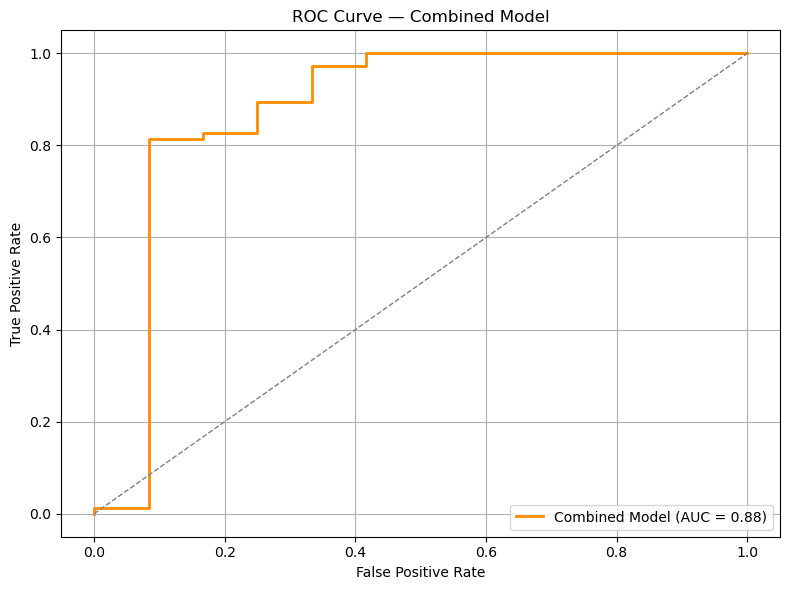

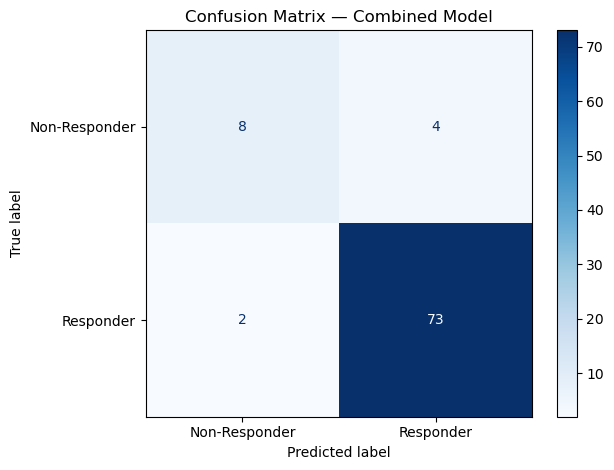

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# === ROC Curve ===
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Combined Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Combined Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Confusion Matrix ===
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=["Non-Responder", "Responder"],
    cmap=plt.cm.Blues,
    values_format='d'
)
plt.title("Confusion Matrix — Combined Model")
plt.grid(False)
plt.tight_layout()
plt.show()
